In [1]:
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)

Welcome to JupyROOT 6.12/06


In [2]:
f = r.TFile("./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root")
f.cd()
f.ls()

TFile**		./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root	
 TFile*		./newPileupHists_gm2offline_ana_60h_pileup_corrected_only.root	
  KEY: TH3D	corrected;1	corrected


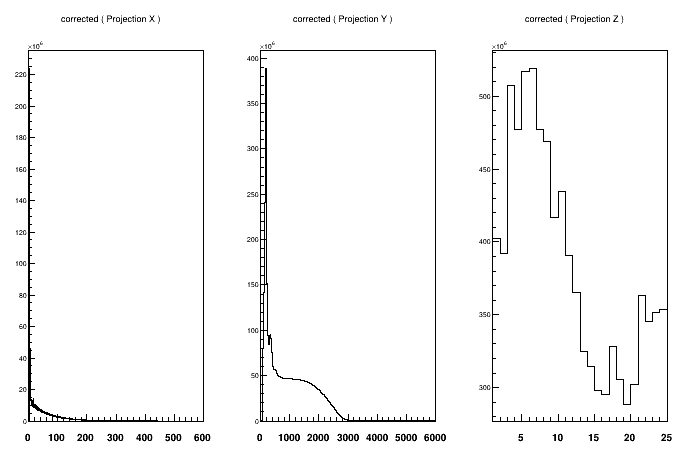

In [3]:
c = r.TCanvas()
c.Divide(3,1)
c.cd(1)
f.corrected.ProjectionX().Draw() #time (us)
c.cd(2)
f.corrected.ProjectionY().Draw() #energy (MeV)
c.cd(3)
f.corrected.ProjectionZ().Draw() # calonum
c.Draw()

In [4]:
#f.corrected.ProjectionX().FindBin(4)

101 201


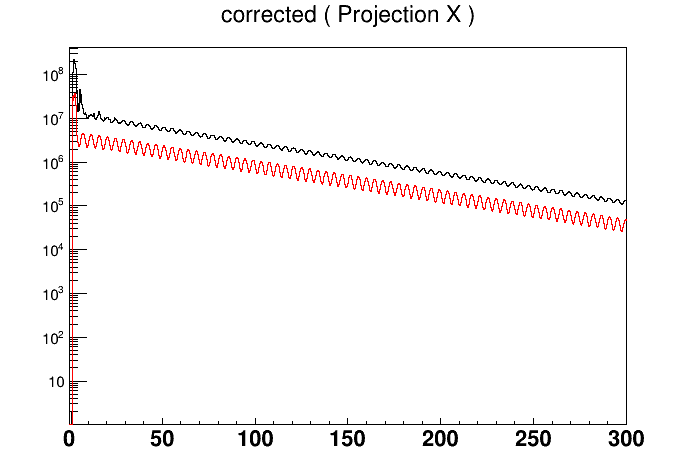

In [5]:
c2 = r.TCanvas()
c2.SetLogy()
h = f.corrected.ProjectionX()
h.GetXaxis().SetRangeUser(0,300)
h.Draw()

#get max an min bins for energy cut. Want the bounds to be > 1300 and < 3000 to match last analysis
# could probably get away with > 1000

energyhist = f.corrected.ProjectionY()
minenergybin = energyhist.FindBin(1500) #try switching from 1000 -> 1500 
maxenergybin = energyhist.FindBin(3000)
print(minenergybin,maxenergybin)

h2 = f.corrected.ProjectionX("px_cut",minenergybin,maxenergybin,0,-1,"")
h2.SetLineColor(2)
h2.Draw("SAME")

c2.Draw()

In [6]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'This is my fight song. Blinding my plot song.')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
#    omega = myBlinder.paramToFreq(R) unblind version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


 FCN=7859.81 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS        1210 TOTAL
                     EDM=1.14853e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            3.92578e+06   2.02570e+02   1.10592e-01   4.05109e-11
   2  #tau         6.44063e+01   1.91858e-03  -5.71915e-07  -2.24945e-05
   3  A           -3.32386e-01   3.79855e-05  -5.54096e-09  -9.12723e-06
   4  R           -1.53737e+01   1.34160e+00  -1.37463e-04  -1.07653e-07
   5  #phi        -1.11006e+02   2.14613e-04   2.14613e-04   7.30553e-04


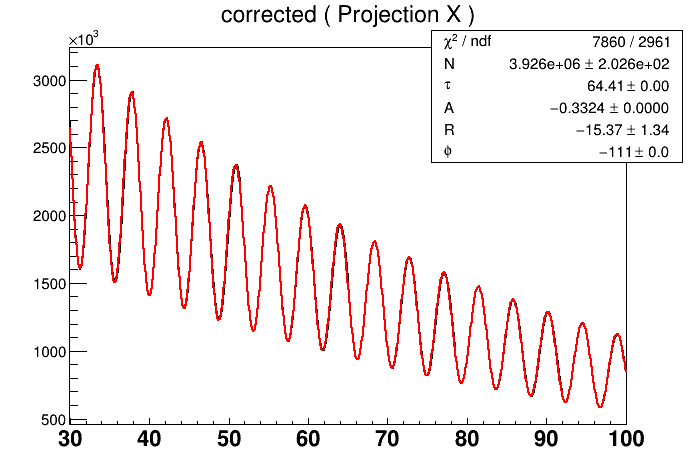

In [7]:
ding = "full_fit"
func = r.TF1(ding, blinded_wiggle, 30,400,5)
func.SetParNames('N','#tau','A','R','#phi')
func.SetParameters(1500,64.4,0.4,-15,0)
func.SetLineColor(2)
func.SetNpx(1000)
r.gStyle.SetOptFit(111)

c = r.TCanvas()
h2.SetLineColor(1)
h2.Draw()
h2.GetXaxis().SetRangeUser(30,500)
h2.Fit(ding,'REM')
func.Draw("SAME")

h2.GetXaxis().SetRangeUser(30,100)

c.Draw()

In [8]:
#h2.GetXaxis().SetRangeUser(30,100)
#c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: Graph (Potential memory leak).


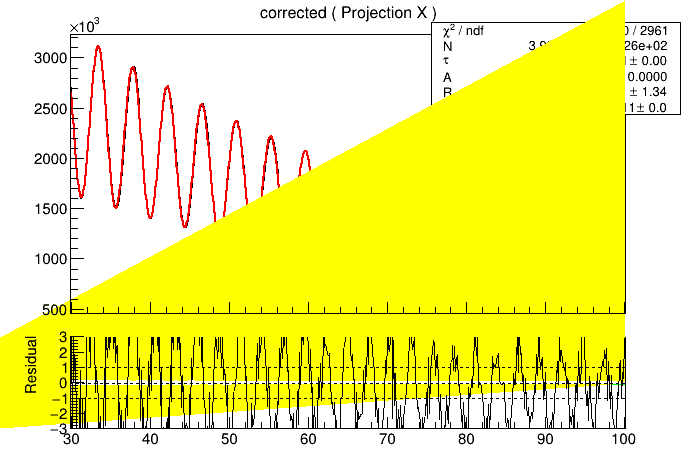

In [9]:
#The class calculates the  difference between the histogram and the fit function at each point 
#    and divides it by the uncertainty.
c2 = r.TCanvas()
rp1 = r.TRatioPlot(h2)
rp1.Draw()
rp1.GetLowerRefYaxis().SetTitle("Residual")
rp1.GetLowerRefYaxis().SetRangeUser(-3,3)
tgraph = rp1.GetCalculationOutputGraph()
dong = r.TGraphAsymmErrors(tgraph)
dong.SetTitle("asym")
c2.Draw()

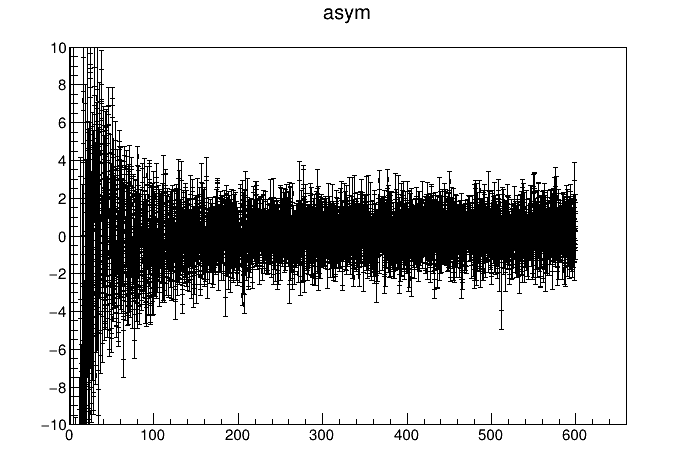

In [10]:
c3 = r.TCanvas()
dong.Draw("a p0 l")
dong.GetYaxis().SetRangeUser(-10,10)
c3.Draw()

In [11]:
ratiolist = []
ratiolist.append(dong)
namelist = ['full']

Number of bins: 4765 ; Total Time range: 590.0228642693827
Center of min/max bin: 9.665350239035543  /  599.6882145084182
Width of each bin: 0.12382431569137098
Maximum Frequency / Sampling Rate (MHz): 8.075958218840272


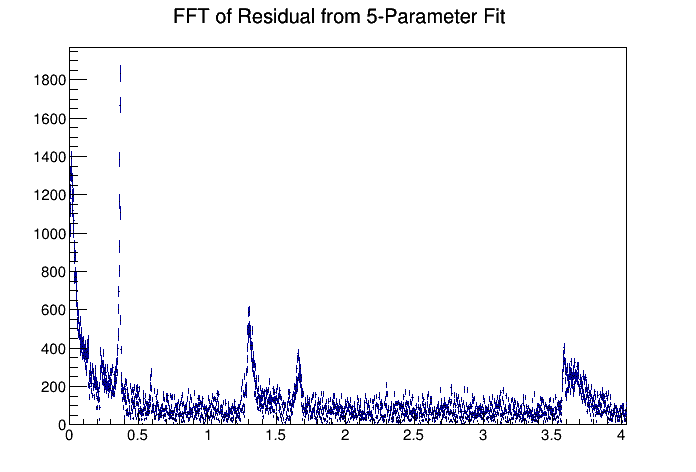

In [12]:
residxformlist = []
for j in range(0,len(namelist)):
    c3 = r.TCanvas()
    tgraph3 = ratiolist[j]
    c3.Draw()
    residualN = tgraph3.GetN() - 2
    listx = []
    listy = []
    minbin = 33 #cut out the first few microseconds where there is no data
    for i in range(minbin,residualN):
        xi = r.Double(9999)
        yi = r.Double(9999)
        tgraph3.GetPoint(i,xi,yi)
        listx.append(xi)
        listy.append(yi)
    #print(listx)
    
    import numpy
    window = numpy.bartlett(residualN)
    listywindow = []
    for i in range(minbin,residualN-minbin):
        listywindow.append(listy[i])#*window[i])
    fftyreal = numpy.real(numpy.fft.fft(listywindow))
    fftyim = numpy.imag(numpy.fft.fft(listywindow))
    ffty = []
    for i in range(0,len(fftyreal)):
        fftyi = numpy.sqrt(fftyreal[i]**2 + fftyim[i]**2)
        ffty.append(fftyi)
#    print(ffty)

    Npart = residualN - minbin
    minBinCenter = listx[minbin]
    maxBinCenter = listx[len(listx)-1]
    capT = maxBinCenter - minBinCenter
    print("Number of bins:", Npart, "; Total Time range:", capT)
    print("Center of min/max bin:", minBinCenter, " / ", maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print("Width of each bin:",deltaT)
#    print("Frequency of each bin:", deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9))) #Hz
    limmaxMHz = limmaxHz / math.pow(10,6) #MHz

    print("Maximum Frequency / Sampling Rate (MHz):",limmaxMHz)

    hresid = r.TH1D("hresid","FFT of Residual from 5-Parameter Fit",residualN,0,residualN)
    for i in range(0,len(ffty)):
        hresid.SetBinContent(i,ffty[i])
    hresid.SetBins(residualN,0,limmaxMHz)
    hresid.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    
    #hresid.Scale(1/(hresid.Integral()))
    
    hresid.Draw("HIST P0 L")
    
    c3.Draw()
    
    residxformlist.append(hresid.DrawClone(namelist[j]+"residxform"))

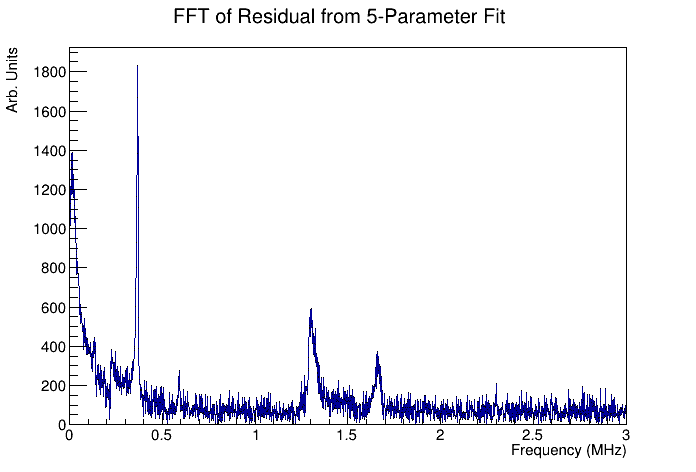

In [13]:
c4 = r.TCanvas()
hresid.Draw("P0 L")
hresid.GetXaxis().SetRangeUser(0,3)
hresid.GetXaxis().SetTitle("Frequency (MHz)")
hresid.GetYaxis().SetTitle("Arb. Units")
c4.Draw()

In [14]:
from matplotlib import pyplot as plt
plt.plot(listy[25:])
plt.plot(listywindow[25:])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [15]:
def peak_fit_bw(x, p):
    return p[0]*r.TMath.BreitWigner(x[0],p[1],p[2]) + p[3]

def peak_fit_simple(x, p):
    return p[0]*r.TMath.Exp(-0.5*((x[0]-p[1])/p[2])*((x[0]-p[1])/p[2])) + p[3]

func1 = r.TF1("peak1", peak_fit_simple, .36,.37,4)
func1.SetParNames('A','Mean','#gamma','+ C')
func1.SetParameters(.0001,.365,.1,0)
func1.SetParLimits(1,.36,.37)
func1.SetLineColor(2)
func1.SetNpx(1000)

func2 = r.TF1("peak2", peak_fit_simple, 1.2,1.4,4)
func2.SetParNames('A','Mean','#gamma','+ C')
func2.SetParameters(.3,1.37,-1)
func2.SetParLimits(1,1.2,1.4)

func3 = r.TF1("peak3", peak_fit_simple, 1.55,1.75,4)
func3.SetParNames('A','Mean','#gamma','+ C')
func3.SetParameters(.3,.37,-1)

 FCN=47.9694 FROM MINOS     STATUS=SUCCESSFUL     80 CALLS         322 TOTAL
                     EDM=5.81779e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            8.57646e+02   4.41062e+01   2.08813e-02   1.58024e-06
   2  Mean         3.66576e-01   9.89669e-05   4.26936e-05   7.81274e-03
   3  #gamma       1.90562e-03   1.52652e-04  -6.18957e-08   2.34659e-01
   4  + C          9.43209e+02   3.89591e+01   3.89591e+01   1.70347e-05
 FCN=3116.43 FROM MINOS     STATUS=SUCCESSFUL     56 CALLS         253 TOTAL
                     EDM=1.20973e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            3.85193e+02   4.86778e+00  -5.99604e-03   4.09034e-06
   2  Mean         1.31440e+00   

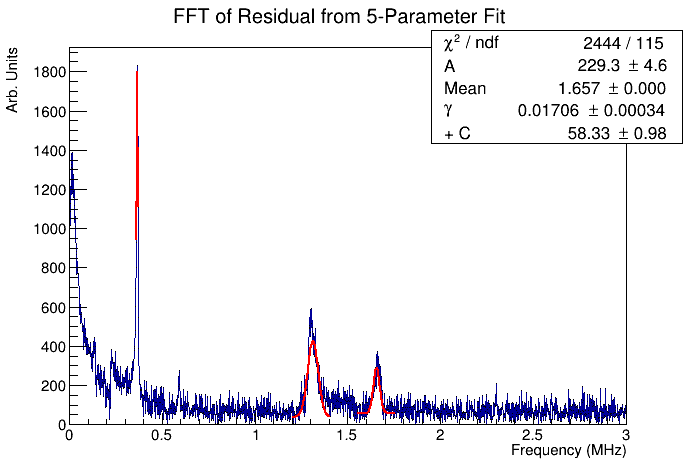

In [28]:
c5 = r.TCanvas()
hresid.Draw("P0 L")
hresid.GetXaxis().SetRangeUser(0,3)
hresid.GetXaxis().SetTitle("Frequency (MHz)")
hresid.GetYaxis().SetTitle("Arb. Units")
hresid.Fit("peak1","REMB")
hresid.Fit("peak2","REMB")
hresid.Fit("peak3","REMB")
func1.Draw("SAME")
func2.Draw("SAME")
func3.Draw("SAME")
hresid.GetXaxis().SetRangeUser(0,3)
c5.Draw()

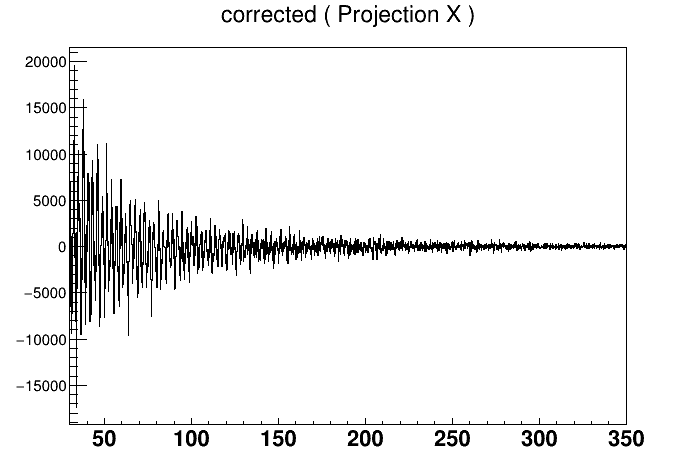

In [17]:
h5 = f.corrected.ProjectionX("px_cut",minenergybin,maxenergybin,0,-1,"")
c5 = r.TCanvas()
#c5.SetLogy()

for i in range(0,h2.GetNbinsX()-2):
    bincenter = h2.GetBinCenter(i)
    bincontent = h2.GetBinContent(i)
#    print(bincenter,bincontent)
    dong = bincontent - func.Eval(bincenter)
    h5.SetBinContent(i,dong)

h5.GetXaxis().SetRangeUser(30,350)
#h5.GetYaxis().SetRangeUser(-0.002,0.002)
    
h5.Draw()
#func.Draw("SAME")
c5.Draw()

4659
18.7071294949075  -  599.6258574101018
18.7071294949075


Warning in <TFile::Append>: Replacing existing TH1: h6 (Potential memory leak).


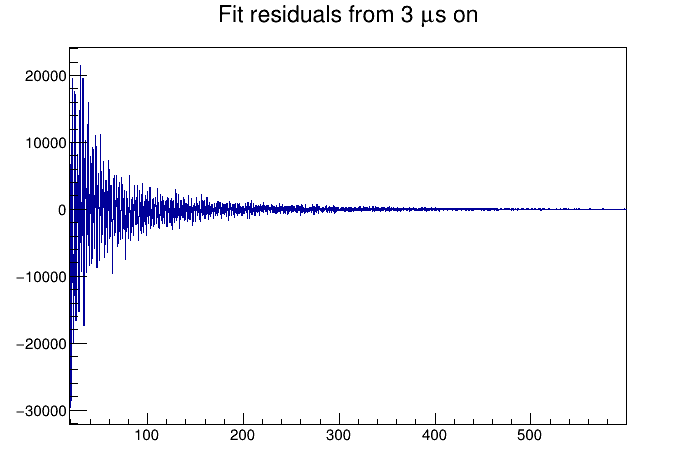

In [25]:
minbin = 150#33
maxbin = h5.GetNbinsX()-2

h6 = r.TH1D("h6","Fit residuals from 3 #mus on",int(h5.GetNbinsX()-2-minbin),0, 100)
for i in range(minbin,h5.GetNbinsX()-2):
    h6.SetBinContent(i-minbin,h5.GetBinContent(i))
    
print(h6.GetNbinsX())
    
h6min = h5.GetBinCenter(minbin) + h5.GetBinWidth(minbin)/2.0
h6max = h5.GetBinCenter(maxbin) - h5.GetBinWidth(maxbin)/2.0

print(h6min," - ", h6max)
h6.SetBins(h6.GetNbinsX(),h6min,h6max)

print(h6.GetBinCenter(0) + h6.GetBinWidth(0)/2.0)
    
c6 = r.TCanvas()
h6.Draw()
c6.Draw()

4659 580.9187279151943 18.644785780814864 599.5635136960092
0.12468742818527458 0.0017214111922141122
16.040109489051098 8.020054744525549


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


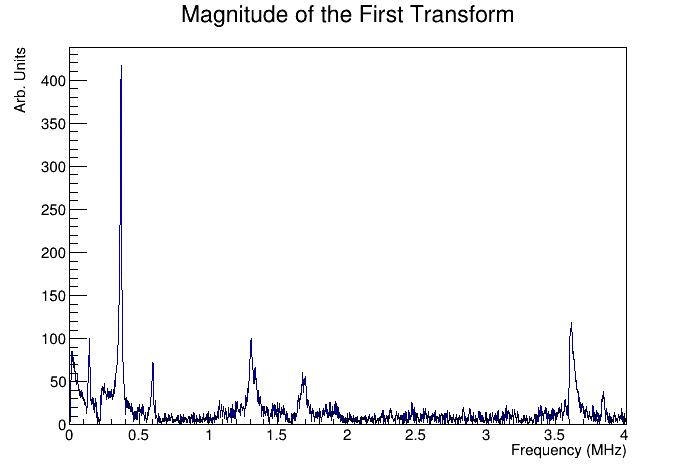

In [26]:
hxform = r.TH1D()
hxform = 0
r.TVirtualFFT.SetTransform(0)
h = h6
hxform = h.FFT(hxform,"MAG P")
hxform.SetTitle("Magnitude of the First Transform")
#NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
#    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
normXform = hxform.GetEntries()
hxform.Scale(1/normXform)
#hxform.GetXaxis().SetRangeUser(0,limmax)
c2 = r.TCanvas()
c2.cd()
#c2.SetLogy()
hxform.GetXaxis().SetTitle("Frequency (MHz)")
hxform.GetYaxis().SetTitle("Arb. Units")
hxform.Draw("HIST P0 L")
c2.Draw()

Npart = h.GetSize() - 2
minBinCenter = h.GetXaxis().GetBinCenter(0)
maxBinCenter = h.GetXaxis().GetBinCenter(Npart)
#    minBinCenter = 0
#    maxBinCenter = 392.85
capT = maxBinCenter - minBinCenter
print(Npart, capT, minBinCenter, maxBinCenter)
deltaT = capT/Npart #microseconds
deltaF = 1/capT
print(deltaT, deltaF)

deltaTns = deltaT*1000 #nanoseconds
limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
limmaxMHz = limmaxHz / math.pow(10,6)

limmax = 2*deltaF*Npart #400-25
print(limmax,limmaxMHz)
#hxform.GetXaxis().SetLimits(0,limmax)
nbins = h.GetSize() - 2
hxform.SetBins(Npart,0,limmaxMHz)
hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)

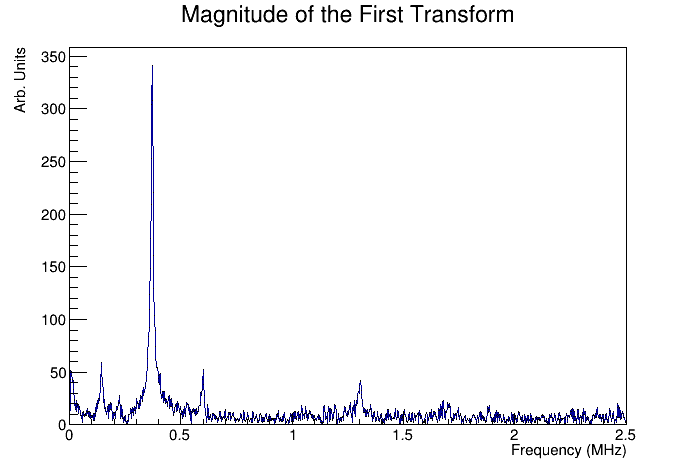

In [20]:
c = r.TCanvas()
hxform.Draw("HIST P0 L")
hxform.GetXaxis().SetRangeUser(0,2.5)
c.Draw()